In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.text import *

In [3]:
PATH = Path('data/translate')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)
fname='giga-fren.release2.fixed'
en_fname = PATH/f'{fname}.en'
fr_fname = PATH/f'{fname}.fr'

In [4]:
qs = pickle.load((PATH/'fr-en-qs.pkl').open('rb'))

In [5]:
qs[:5], len(qs)

([('What is light ?', 'Qu’est-ce que la lumière?'),
  ('Who are we?', 'Où sommes-nous?'),
  ('Where did we come from?', "D'où venons-nous?"),
  ('What would we do without it?', 'Que ferions-nous sans elle ?'),
  ('What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?',
   'Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?')],
 52331)

In [6]:
en_qs,fr_qs = zip(*qs)

In [7]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_qs))

In [8]:
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_qs), 'fr')

In [9]:
en_tok[0], fr_tok[0]

(['what', 'is', 'light', '?'],
 ['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?'])

In [10]:
np.percentile([len(o) for o in en_tok], 90), np.percentile([len(o) for o in fr_tok], 90)

(23.0, 28.0)

In [11]:
keep = np.array([len(o)<30 for o in en_tok])

In [12]:
en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

In [13]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common(40000)]
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

In [14]:
en_ids,en_itos,en_stoi = toks2ids(en_tok,'en')
fr_ids,fr_itos,fr_stoi = toks2ids(fr_tok,'fr')

In [15]:
def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [16]:
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

In [17]:
[fr_itos[o] for o in fr_ids[0]], len(en_itos), len(fr_itos)

(['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?', '_eos_'], 17573, 24793)

In [18]:
import fastText as ft

In [19]:
def get_vecs(lang, ft_vecs):
    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
    return vecd

In [20]:
en_vecd = pickle.load(open(PATH/'wiki.en.pkl','rb'))
fr_vecd = pickle.load(open(PATH/'wiki.fr.pkl','rb'))

In [21]:
dim_en_vec = len(en_vecd[','])
dim_fr_vec = len(fr_vecd[','])
dim_en_vec,dim_fr_vec

(300, 300)

In [22]:
en_vecs = np.stack(list(en_vecd.values()))
en_vecs.mean(),en_vecs.std()

(0.0075652334, 0.29283327)

In [23]:
def reversals(en, fr, rev_eng = False, rev_fre = False):
    if (rev_eng and rev_fre):
        en_rev = [a[::-1][1:]+a[::-1][0:1] for a in en]
        fr_rev = [a[::-1][1:]+a[::-1][0:1] for a in fr]
        return en_rev,fr_rev
    elif (rev_eng):
        en_rev = [a[::-1][1:]+a[::-1][0:1] for a in en]
        return en_rev
    elif (rev_fre):
        fr_rev = [a[::-1][1:]+a[::-1][0:1] for a in fr]
        return fr_rev
    else:
        print ("Error in Reversals Code.")

In [24]:
enlen_99 = int(np.percentile([len(o) for o in en_ids], 99))
frlen_97 = int(np.percentile([len(o) for o in fr_ids], 97))
enlen_99,frlen_97

(29, 33)

In [83]:
enlen_90 = int(np.percentile([len(o) for o in en_ids], 90))
frlen_90 = int(np.percentile([len(o) for o in fr_ids], 90))
enlen_90,frlen_90

(21, 26)

In [84]:
enlen_100 = int(np.percentile([len(o) for o in en_ids], 100))
frlen_100 = int(np.percentile([len(o) for o in fr_ids], 100))
enlen_100,frlen_100

(30, 122)

In [25]:
en_ids_tr = np.array([o[:enlen_99] for o in en_ids])
fr_ids_tr = np.array([o[:frlen_97] for o in fr_ids])

In [26]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)

In [27]:
np.random.seed(42)
trn_keep = np.random.rand(len(en_ids_tr))>0.1
en_trn,fr_trn = en_ids_tr[trn_keep],fr_ids_tr[trn_keep]
en_val,fr_val = en_ids_tr[~trn_keep],fr_ids_tr[~trn_keep]
len(en_trn),len(en_val)

(45219, 5041)

In [28]:
en_trn_rev, fr_trn_rev = reversals(en = en_trn, fr = fr_trn, rev_eng = True, rev_fre = True)
en_val_rev, fr_val_rev = reversals(en = en_val, fr = fr_val, rev_eng = True, rev_fre = True)

In [29]:
#Normal Dataset - Both French and English sentences are straight
trn_ds = Seq2SeqDataset(fr_trn,en_trn)
val_ds = Seq2SeqDataset(fr_val,en_val)

In [30]:
#Test Dataset 1 - French(Source) is reversed and English(Target) is straight
trn_ds_1 = Seq2SeqDataset(fr_trn_rev,en_trn)
val_ds_1 = Seq2SeqDataset(fr_val_rev,en_val)

In [31]:
#Test Dataset 2 - French(Source) is straight and English(Target) is reversed
trn_ds_2 = Seq2SeqDataset(fr_trn,en_trn_rev)
val_ds_2 = Seq2SeqDataset(fr_val,en_val_rev)

In [32]:
#Test Dataset 3 - Both French and English are reversed
trn_ds_3 = Seq2SeqDataset(fr_trn_rev,en_trn_rev)
val_ds_3 = Seq2SeqDataset(fr_val_rev,en_val_rev)

In [33]:
bs=125
nh,nl = 256,2

In [34]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

In [35]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
        output = self.m(*xs, y)
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data[0]

In [36]:
class Seq2SeqRNN_TeacherForcing(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 1.
        
    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [37]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [56]:
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w]*3)
        except: miss.append(w)
    print(len(miss),miss[5:10])
    return emb

## Normal Dataset

In [38]:
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [39]:
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [40]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(33, 29), (21, 7), (21, 8), (33, 13), (33, 21)]

In [43]:
rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_99)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


 66%|██████▌   | 238/362 [00:43<00:22,  5.50it/s, loss=31.2]

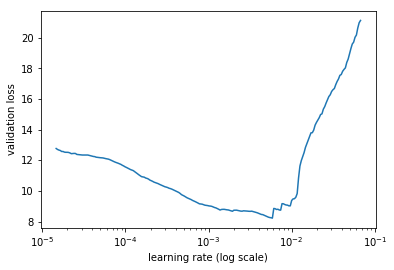

In [44]:
learn.lr_find()
learn.sched.plot()

In [46]:
lr=3e-3

In [47]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), stepper=Seq2SeqStepper)

epoch      trn_loss   val_loss                              
    0      3.770847   8.513971  
    1      3.378469   8.001781                              
    2      3.028419   6.072838                              
    3      2.897162   4.678954                              
    4      2.844882   4.52825                               
    5      2.863175   4.037238                              
    6      2.700316   3.748082                              
    7      2.739801   3.70536                               
    8      2.850697   3.55738                               
    9      2.97383    3.53295                               
    10     2.716448   3.464918                              
    11     2.706294   3.41725                               


[array([3.41725])]

In [48]:
learn.save('normal')

In [49]:
learn.load('normal')

In [51]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(0,10):
    print([fr_itos[o] for o in x[:,i] if o != 1])
    print([en_itos[o] for o in y[:,i] if o != 1])
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1])
    print()

['croyez', '-', 'vous', 'que', 'le', 'secteur', 'canadien', 'du', 'porc', 'pourrait', 'mieux', 'fabler', 'sur', 'les', 'possibilités', 'du', 'marché', 'pour', 'ma~', 'son', 'potentiel', 'commercial', 'au', 'cours', 'des', 'cinq', 'prochaines', 'années', '?', '_eos_']
['which', 'countries', 'do', 'you', 'feel', 'are', 'likely', 'to', 'be', 'the', 'most', 'fo', '~', 'midable', 'competition', 'for', 'the', 'canadian', 'hog', '-', 'po~', 'sector', 'over', 'the', 'next', 'five', 'years', '?', '_eos_']
['what', 'is', 'the', 'the', 'of', 'the', 'the', 'the', 'the', 'the', 'the', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'the', '?', '?', '?', '?', '_eos_']

['quels', 'principaux', 'obstacles', 'limitent', "l'", 'accès', 'à', 'ces', 'marchés', 'et', 'quelles', 'mesures', "l'", 'industrie', 'et', 'le', 'gouvernement', 'pourraient', '-', 'ils', 'prendre', 'pour', 'rendre', 'le', 'porc', 'du', 'manitoba', 'plus', 'concurrentiel', 'sur', 'ces', 'marchés', 'en']
['what', 'are', 'the', 'major', 'impe

## Test 1 

In [53]:
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [54]:
trn_dl = DataLoader(trn_ds_1, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds_1, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [55]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(33, 29), (33, 16), (29, 13), (33, 8), (33, 20)]

In [57]:
rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_99)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [58]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), stepper=Seq2SeqStepper)

epoch      trn_loss   val_loss                              
    0      3.6144     11.153067 
    1      3.236925   7.617097                              
    2      3.273386   6.124528                              
    3      3.215901   4.477503                              
    4      3.167266   4.664958                              
    5      3.24353    4.262458                              
    6      2.869129   3.94471                               
    7      2.876016   3.82358                               
    8      2.938379   3.619175                              
    9      2.934167   3.776458                              
    10     2.888705   3.565312                              
    11     2.832448   3.498366                              


[array([3.49837])]

In [59]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(0,10):
    print([fr_itos[o] for o in x[:,i] if o != 1])
    print([en_itos[o] for o in y[:,i] if o != 1])
    print([en_itos[o] for o in preds[:,i] if o!=1])
    print()

['?', 'années', 'prochaines', 'cinq', 'des', 'cours', 'au', 'commercial', 'potentiel', 'son', 'ma~', 'pour', 'marché', 'du', 'possibilités', 'les', 'sur', 'fabler', 'mieux', 'pourrait', 'porc', 'du', 'canadien', 'secteur', 'le', 'que', 'vous', '-', 'croyez', '_eos_']
['which', 'countries', 'do', 'you', 'feel', 'are', 'likely', 'to', 'be', 'the', 'most', 'fo', '~', 'midable', 'competition', 'for', 'the', 'canadian', 'hog', '-', 'po~', 'sector', 'over', 'the', 'next', 'five', 'years', '?', '_eos_']
['what', 'do', 'you', 'see', 'the', 'the', 'the', 'in', 'in', 'in', 'in', '?', '?', '?', '_eos_']

['marchés', 'ces', 'sur', 'concurrentiel', 'plus', 'manitoba', 'du', 'porc', 'le', 'rendre', 'pour', 'prendre', 'ils', '-', 'pourraient', 'gouvernement', 'le', 'et', 'industrie', "l'", 'mesures', 'quelles', 'et', 'marchés', 'ces', 'à', 'accès', "l'", 'limitent', 'obstacles', 'principaux', 'quels', 'en']
['what', 'are', 'the', 'major', 'impediments', 'to', 'accessing', 'these', 'markets', ',', 'an

In [60]:
learn.save('Test1')

In [61]:
learn.load('Test1')

## Test 2 

In [116]:
trn_samp = SortishSampler(en_trn_rev, key=lambda x: len(en_trn_rev[x]), bs=bs)
val_samp = SortSampler(en_val_rev, key=lambda x: len(en_val_rev[x]))

In [117]:
trn_dl = DataLoader(trn_ds_2, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds_2, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [64]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(33, 29), (25, 13), (33, 20), (33, 13), (15, 7)]

In [65]:
rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_99)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [66]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), stepper=Seq2SeqStepper)

epoch      trn_loss   val_loss                              
    0      3.782766   12.071773 
    1      3.37465    6.194603                              
    2      2.960599   5.946634                              
    3      2.852992   5.763406                              
    4      2.869113   5.0555                                
    5      2.844296   4.4803                                
    6      2.966632   3.896077                              
    7      3.026155   3.786117                              
    8      2.888877   3.748351                              
    9      2.802807   3.583114                              
    10     3.023529   3.545996                              
    11     2.893101   3.529499                              


[array([3.5295])]

In [67]:
learn.save('Test2')

In [118]:
learn.load('Test2')

In [120]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(0,10):
    #print (len(x[:,i]))
    print([fr_itos[o] for o in x[:,i] if o != 1])
    print([en_itos[o] for o in y[:,i] if o != 1])
    print([en_itos[o] for o in preds[:,i] if o!=1])
    print()

['croyez', '-', 'vous', 'que', 'le', 'secteur', 'canadien', 'du', 'porc', 'pourrait', 'mieux', 'fabler', 'sur', 'les', 'possibilités', 'du', 'marché', 'pour', 'ma~', 'son', 'potentiel', 'commercial', 'au', 'cours', 'des', 'cinq', 'prochaines', 'années', '?', '_eos_']
['?', 'years', 'five', 'next', 'the', 'over', 'sector', 'po~', '-', 'hog', 'canadian', 'the', 'for', 'competition', 'midable', '~', 'fo', 'most', 'the', 'be', 'to', 'likely', 'are', 'feel', 'you', 'do', 'countries', 'which', '_eos_']
['?', 'years', 'next', 'the', 'in', 'market', 'market', 'the', 'market', 'the', 'the', 'market', 'the', 'the', 'the', 'the', 'the', 'you', 'you', 'do', 'you', '_eos_', '_eos_']

['quels', 'principaux', 'obstacles', 'limitent', "l'", 'accès', 'à', 'ces', 'marchés', 'et', 'quelles', 'mesures', "l'", 'industrie', 'et', 'le', 'gouvernement', 'pourraient', '-', 'ils', 'prendre', 'pour', 'rendre', 'le', 'porc', 'du', 'manitoba', 'plus', 'concurrentiel', 'sur', 'ces', 'marchés', 'en']
['?', 'markets'

## Test 3 

In [121]:
trn_samp = SortishSampler(en_trn_rev, key=lambda x: len(en_trn_rev[x]), bs=bs)
val_samp = SortSampler(en_val_rev, key=lambda x: len(en_val_rev[x]))

In [122]:
trn_dl = DataLoader(trn_ds_3, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds_3, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [72]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(33, 29), (33, 15), (33, 24), (21, 8), (29, 16)]

In [73]:
rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_99)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [74]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), stepper=Seq2SeqStepper)

epoch      trn_loss   val_loss                              
    0      3.846422   15.127836 
    1      3.09523    7.713141                              
    2      2.815066   7.12444                               
    3      2.821907   6.299391                              
    4      2.755504   4.710751                              
    5      2.888454   4.240161                              
    6      2.877773   4.031064                              
    7      2.881096   3.861464                              
    8      2.856704   3.692176                              
    9      2.96854    3.587662                              
    10     3.002486   3.553226                              
    11     2.920857   3.495219                              


[array([3.49522])]

In [75]:
learn.save('Test3')

In [123]:
learn.load('Test3')

In [125]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])


for i in range(0,10):
    print([fr_itos[o] for o in x[:,i] if o != 1])
    print([en_itos[o] for o in y[:,i] if o != 1])
    print([en_itos[o] for o in preds[:,i] if o!=1])
    print()

['?', 'années', 'prochaines', 'cinq', 'des', 'cours', 'au', 'commercial', 'potentiel', 'son', 'ma~', 'pour', 'marché', 'du', 'possibilités', 'les', 'sur', 'fabler', 'mieux', 'pourrait', 'porc', 'du', 'canadien', 'secteur', 'le', 'que', 'vous', '-', 'croyez', '_eos_']
['?', 'years', 'five', 'next', 'the', 'over', 'sector', 'po~', '-', 'hog', 'canadian', 'the', 'for', 'competition', 'midable', '~', 'fo', 'most', 'the', 'be', 'to', 'likely', 'are', 'feel', 'you', 'do', 'countries', 'which', '_eos_']
['?', 'years', 'next', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'you', 'you', 'you', 'you', 'you', 'what', 'what', 'what', 'what', '_eos_']

['marchés', 'ces', 'sur', 'concurrentiel', 'plus', 'manitoba', 'du', 'porc', 'le', 'rendre', 'pour', 'prendre', 'ils', '-', 'pourraient', 'gouvernement', 'le', 'et', 'industrie', "l'", 'mesures', 'quelles', 'et', 'marchés', 'ces', 'à', 'accès', "l'", 'limitent', 'obstacles', 'principaux', 'quels', 'en']
['?', 'markets', 'expanding', 'these'

# With LSTMs

In [78]:
class Seq2SeqRNN_TeacherForcing_LSTM(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.lstm_enc = nn.LSTM(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.lstm_dec = nn.LSTM(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 1.
        
    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))